# Developing a unified representation of Alzheimer’s subtypes

# Part 3: Cluster Correlation Assessment

After isolating the data per modality with each subject being assigned a subtype and stage this notebook will assess the different subtype correlation. 
MRI we found 4 cluster, AB 2 and TAU 4. 
I will run individual assessments between modalities and see if I can isolate unified representations of AD subtypes. 

## Import Packages 

In [1]:
# import the python packages needed to generate simulated data for the tutorial
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.interpolate import make_interp_spline
from scipy.stats import kendalltau
from scipy.interpolate import PchipInterpolator
import sklearn.model_selection
import sys
import shutil
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*figure layout has changed to tight.*")
from itertools import combinations, product
from pathlib import Path
import pickle


sys.path.insert(0,'/Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/')

## 1. reading relevant data: 

In [2]:
zdata_mri = pd.read_csv("Train_MRI_SuStaIn_1.csv")
zdata_mri['Modality'] = 'MRI'

zdata_ab = pd.read_csv("Train_AB_SuStaIn_2.csv")
zdata_ab['Modality'] = 'AB'

zdata_tau = pd.read_csv("Train_TAU_SuStaIn_3.csv")
zdata_tau['Modality'] = 'TAU'


In [3]:
def standardize_label(label, modality):
    # Map known patterns to standardized lobe names
    lobe_map = {
        "mtl": "MTL",
        "temporal": "Temporal_Lobe",
        "parietal": "Parietal_Lobe",
        "frontal": "Frontal_Lobe",
        "occipital": "Occipital_Lobe"
    }

    # Lowercase and remove suffixes
    label_clean = (
        label.lower()
        .replace("_suvr_weighted", "")
        .replace("_volume", "")
        .replace("_suvr", "")
        .replace("_weighted_tau", "")
        .replace("_", "")
    )

    # Match lobe name
    for key in lobe_map:
        if key in label_clean:
            return f"{lobe_map[key]}"
    
    return f"UnknownLobe"


In [4]:
#Sustain data per modality
N_startpoints = 50

#MRI
N_S_max_mri = 4
N_iterations_MCMC = int(1e5)
output_folder_mri = os.path.join(os.getcwd(), 'MRIOutput')
dataset_name_mri = 'MRIOutput'
pickle_filename_s_mri = output_folder_mri + '/pickle_files/' + dataset_name_mri + '_subtype' + str(N_S_max_mri-1) + '.pickle'
pk_mri = pd.read_pickle(pickle_filename_s_mri)
samples_sequence_mri = pk_mri["samples_sequence"]
samples_f_mri = pk_mri["samples_f"]

biomarkers_mri = ['Frontal_lobe_volume', 'Occipital_lobe_volume', 'Parietal_lobe_volume','Temporal_lobe_volume', 'MTL_volume']
N_mri = len(biomarkers_mri)    
SuStaInLabels_mri = [standardize_label(b, "MRI") for b in biomarkers_mri]
Z_vals_mri = np.array([[2,3,4.5]]*N_mri)     # Z-scores for each biomarker
Z_max_mri  = np.ceil(np.percentile(zdata_mri[biomarkers_mri].values,99,axis=0)).astype('int')           # maximum z-score

sustain_input_mri = pySuStaIn.ZscoreSustain(
                              zdata_mri[biomarkers_mri].values,
                              Z_vals_mri,
                              Z_max_mri,
                              SuStaInLabels_mri,
                              N_startpoints,
                              N_S_max_mri, 
                              N_iterations_MCMC, 
                              output_folder_mri, 
                              dataset_name_mri, 
                              False)

pickle_filepath_mri             = Path(pickle_filename_s_mri)
pickle_file_mri                 = open(pickle_filename_s_mri, 'rb')
loaded_variables_mri            = pickle.load(pickle_file_mri)
ml_subtype_mri                  = loaded_variables_mri["ml_subtype"]
prob_ml_subtype_mri             = loaded_variables_mri["prob_ml_subtype"]
ml_stage_mri                    = loaded_variables_mri["ml_stage"]
prob_ml_stage_mri               = loaded_variables_mri["prob_ml_stage"]
prob_subtype_mri                = loaded_variables_mri["prob_subtype"]
prob_stage_mri                  = loaded_variables_mri["prob_stage"]
prob_subtype_stage_mri          = loaded_variables_mri["prob_subtype_stage"]
ml_seq_mri                      = loaded_variables_mri["ml_sequence_EM"]
pickle_file_mri.close()    

#AB
N_S_max_ab = 2
output_folder_ab = os.path.join(os.getcwd(), 'ABOutput')
dataset_name_ab = 'ABOutput'
pickle_filename_s_ab = output_folder_ab + '/pickle_files/' + dataset_name_ab + '_subtype' + str(N_S_max_ab-1) + '.pickle'
pk_ab = pd.read_pickle(pickle_filename_s_ab)
samples_sequence_ab = pk_ab["samples_sequence"]
samples_f_ab = pk_ab["samples_f"]

biomarkers_ab = ['Frontal_lobe_SUVR_weighted_ab', 'Occipital_lobe_SUVR_weighted_ab','Parietal_lobe_SUVR_weighted_ab', 'Temporal_lobe_SUVR_weighted_ab','MTL_SUVR_weighted_ab']
N_ab = len(biomarkers_ab)      
SuStaInLabels_ab = [standardize_label(b, "AB") for b in biomarkers_ab]
Z_vals_ab = np.array([[1,2,3.5]]*N_ab)     # Z-scores for each biomarker
Z_max_ab  = np.ceil(np.percentile(zdata_ab[biomarkers_ab].values,99,axis=0)).astype('int')           # maximum z-score
sustain_input_ab = pySuStaIn.ZscoreSustain(
                              zdata_ab[biomarkers_ab].values,
                              Z_vals_ab,
                              Z_max_ab,
                              SuStaInLabels_ab,
                              N_startpoints,
                              N_S_max_ab, 
                              N_iterations_MCMC, 
                              output_folder_ab, 
                              dataset_name_ab, 
                              False)

pickle_filepath_ab             = Path(pickle_filename_s_ab)
pickle_file_ab                 = open(pickle_filename_s_ab, 'rb')
loaded_variables_ab            = pickle.load(pickle_file_ab)
ml_subtype_ab                  = loaded_variables_ab["ml_subtype"]
prob_ml_subtype_ab             = loaded_variables_ab["prob_ml_subtype"]
ml_stage_ab                    = loaded_variables_ab["ml_stage"]
prob_ml_stage_ab               = loaded_variables_ab["prob_ml_stage"]
prob_subtype_ab                = loaded_variables_ab["prob_subtype"]
prob_stage_ab                  = loaded_variables_ab["prob_stage"]
prob_subtype_stage_ab          = loaded_variables_ab["prob_subtype_stage"]
ml_seq_ab                      = loaded_variables_ab["ml_sequence_EM"]
pickle_file_ab.close()              


#TAU
N_S_max_tau = 4
output_folder_tau = os.path.join(os.getcwd(), 'TAUOutput')
dataset_name_tau = 'TAUOutput'
pickle_filename_s_tau = output_folder_tau + '/pickle_files/' + dataset_name_tau + '_subtype' + str(N_S_max_tau-1) + '.pickle'
pk_tau = pd.read_pickle(pickle_filename_s_tau)
samples_sequence_tau = pk_tau["samples_sequence"]
samples_f_tau = pk_tau["samples_f"]

biomarkers_tau = ['Frontal_lobe_SUVR_weighted_tau', 'Occipital_lobe_SUVR_weighted_tau', 'Parietal_lobe_SUVR_weighted_tau', 'Temporal_lobe_SUVR_weighted_tau', 'MTL_SUVR_weighted_tau']
N_tau = len(biomarkers_tau)         
SuStaInLabels_tau = [standardize_label(b, "TAU") for b in biomarkers_tau]
Z_vals_tau = np.array([[3,5,6.5]]*N_tau)     # Z-scores for each biomarker
Z_max_tau  = np.ceil(np.nanpercentile(zdata_tau[biomarkers_tau].values,99,axis=0)).astype('int')           # maximum z-score

sustain_input_tau = pySuStaIn.ZscoreSustain(
                              zdata_tau[biomarkers_tau].values,
                              Z_vals_tau,
                              Z_max_tau,
                              SuStaInLabels_tau,
                              N_startpoints,
                              N_S_max_tau, 
                              N_iterations_MCMC, 
                              output_folder_tau, 
                              dataset_name_tau, 
                              False)

pickle_filepath_tau             = Path(pickle_filename_s_tau)
pickle_file_tau                 = open(pickle_filename_s_tau, 'rb')
loaded_variables_tau            = pickle.load(pickle_file_tau)
ml_subtype_tau                  = loaded_variables_tau["ml_subtype"]
prob_ml_subtype_tau             = loaded_variables_tau["prob_ml_subtype"]
ml_stage_tau                    = loaded_variables_tau["ml_stage"]
prob_ml_stage_tau               = loaded_variables_tau["prob_ml_stage"]
prob_subtype_tau                = loaded_variables_tau["prob_subtype"]
prob_stage_tau                  = loaded_variables_tau["prob_stage"]
prob_subtype_stage_tau          = loaded_variables_tau["prob_subtype_stage"]
ml_seq_tau                      = loaded_variables_tau["ml_sequence_EM"]
pickle_file_tau.close()              


## 2. Assess subtype correlation
To assess the correlation between subtpes we need a common basis for comparison, a progression pattern signature that captures when and how strongly each lobe becomes abnormal across subtypes and stages. 

To do this I defined four functions: 
1. Computes the lobe progression per subtypes per stage by giving the lobe with the highest zscore per stage to the overall subtype from SuStaIn. -Progression Pattern Signature. 
2. Correlates between subtypes between different modalities based on the signatures.

In [5]:
# import numpy as np

# def sort_subtypes_by_frequency(sequences, subtype_assignments, subtype_label_to_index=None):
#     """
#     Sort subtype sequences by descending frequency of subtype assignments.

#     Parameters:
#     - sequences: list of subtype sequences (list of lists)
#     - subtype_assignments: array-like of subtype labels per subject
#     - subtype_label_to_index: dict mapping subtype label -> index in sequences (optional)

#     Returns:
#     - sorted_sequences: sequences sorted by subtype frequency descending
#     - sorted_counts: counts of subjects per subtype sorted descending
#     - index_map: dict mapping original subtype index to sorted index
#     """

#     unique_labels, counts = np.unique(subtype_assignments, return_counts=True)

#     # If no mapping provided, assume labels are zero-based indices directly
#     if subtype_label_to_index is None:
#         subtype_label_to_index = {label: label for label in unique_labels}

#     # Build label -> sequence mapping safely
#     subtype_to_sequence = {}
#     for label in unique_labels:
#         idx = subtype_label_to_index[label]
#         if not (0 <= idx < len(sequences)):
#             raise IndexError(f"Index {idx} for label {label} out of range for sequences length {len(sequences)}")
#         subtype_to_sequence[label] = sequences[idx]

#     # Pair label with counts and sort descending by count
#     label_count_pairs = list(zip(unique_labels, counts))
#     label_count_pairs.sort(key=lambda x: x[1], reverse=True)  # sort by count descending

#     sorted_labels = [pair[0] for pair in label_count_pairs]
#     sorted_counts = np.array([pair[1] for pair in label_count_pairs])
#     sorted_sequences = [subtype_to_sequence[label] for label in sorted_labels]

#     # Create index map from original label to sorted order index
#     index_map = {label: i for i, label in enumerate(sorted_labels)}

#     return sorted_sequences, sorted_counts, index_map


# # === Your subject subtype assignments per modality (must exist) ===
# subject_assignments = {
#     'MRI': ml_subtype_mri,
#     'AB': ml_subtype_ab,
#     'TAU': ml_subtype_tau
# }

# # === Define inputs per modality ===
# modalities = {
#     'MRI': {
#         'sustain_input': sustain_input_mri,
#         'sequences': ml_seq_mri
#     },
#     'AB': {
#         'sustain_input': sustain_input_ab,
#         'sequences': ml_seq_ab
#     },
#     'TAU': {
#         'sustain_input': sustain_input_tau,
#         'sequences': ml_seq_tau
#     }
# }

# # Known z-score stages per modality
# known_zs_dict = {
#     'MRI': [2.00, 3.00, 4.50],
#     'AB': [1.00, 2.00, 3.50],
#     'TAU': [3.00, 5.00, 6.50]
# }

# z_stage_map = {0: "1st", 1: "2nd", 2: "3rd"}

# all_progressions = {}

# for modality, info in modalities.items():
#     sustain_input = info['sustain_input']
#     sequences = info['sequences']
#     assignments = subject_assignments[modality]

#     known_zs = known_zs_dict.get(modality)
#     if known_zs is None:
#         print(f"Warning: No known_zs defined for modality {modality}, skipping...")
#         continue

#     # Create mapping subtype label -> sequence index
#     unique_labels = np.unique(assignments)
#     # Here we map sorted unique labels to 0-based indices for sequences
#     subtype_label_to_index = {label: i for i, label in enumerate(sorted(unique_labels))}

#     sorted_sequences, sorted_counts, idx_map = sort_subtypes_by_frequency(
#         sequences,
#         assignments,
#         subtype_label_to_index=subtype_label_to_index
#     )

#     idxs = sustain_input.stage_biomarker_index[0]
#     zvals = sustain_input.stage_zscore[0]
#     labs = sustain_input.biomarker_labels.copy()

#     print(f"\n==== {modality} Subtype Sequences (Sorted by Subject Count) ====")

#     modality_progressions = []
#     for i, (st_seq, subtype_count) in enumerate(zip(sorted_sequences, sorted_counts), start=1):
#         print(f"\nSubtype {i} (n={subtype_count} subjects):")
#         readable_seq = []
#         for k in st_seq:
#             idx = idxs[int(k)]
#             z = zvals[int(k)]
#             raw_label = labs[int(idx)]

#             # Standardize lobe name
#             lobe = standardize_label(raw_label, modality)

#             # Assign closest z-score stage
#             closest_idx = np.argmin([abs(z - known) for known in known_zs])
#             stage = z_stage_map[closest_idx]

#             final_label = f"{stage}: {lobe}"
#             print(final_label)
#             readable_seq.append(final_label)

#         modality_progressions.append(readable_seq)

#     all_progressions[modality] = modality_progressions


In [7]:
# === Your subject subtype assignments per modality (must exist) ===
subject_assignments = {
    'MRI': ml_subtype_mri,
    'AB': ml_subtype_ab,
    'TAU': ml_subtype_tau
}

# === Define inputs per modality ===
modalities = {
    'AB': {
        'sustain_input': sustain_input_ab,
        'sequences': ml_seq_ab
    },
    'TAU': {
        'sustain_input': sustain_input_tau,
        'sequences': ml_seq_tau
    },
        'MRI': {
        'sustain_input': sustain_input_mri,
        'sequences': ml_seq_mri
    }
}


# Known z-score stages per modality
known_zs_dict = {
    'MRI': [2.00, 3.00, 4.50],
    'AB': [1.00, 2.00, 3.50],
    'TAU': [3.00, 5.00, 6.50]
}

# Manual mapping: old label (original) -> new label (desired) - sustain doesnt output sequences in the correct order
manual_label_map = {
    'MRI': {1: 2, 2: 1, 3: 3, 4: 4},   # remap label 1->2, 2->1, keep 3 & 4
    'AB': {1: 1, 2: 2},                # no change
    'TAU': {1: 2, 2: 4, 3: 1, 4: 3}   # remap 1->2, 2->4, 3->1, 4->3 (adjusted based on your note)
}

# Inverse mapping: new label (desired) -> old label (for sequence indexing)
inverse_manual_label_map = {
    modality: {new_label: old_label for old_label, new_label in mapping.items()}
    for modality, mapping in manual_label_map.items()
}

# Function to remap assignments array per modality
def remap_assignments(assignments, label_map):
    # Cast to int (in case labels are floats) for safe dict lookup
    assignments_int = assignments.astype(int)
    remapped = np.array([label_map.get(label, label) for label in assignments_int])
    return remapped

all_progressions = {}

for modality, info in modalities.items():
    sustain_input = info['sustain_input']
    sequences = info['sequences']
    assignments = np.array(subject_assignments[modality])
    
    # Flatten if needed
    if assignments.ndim > 1:
        assignments = assignments.flatten()
    
    print(f"\n==== {modality} ====")

    # Remap subject assignments using manual mapping
    label_map = manual_label_map.get(modality, {})
    assignments_remapped = remap_assignments(assignments, label_map)

    # Reorder sequences using inverse mapping (new label -> original label)
    inv_map = inverse_manual_label_map.get(modality, {})
    # Sort new labels ascending (1,2,3,...) for final subtype numbering
    new_labels_sorted = sorted(inv_map.keys())
    sequences_reordered = [sequences[inv_map[new_label] - 1] for new_label in new_labels_sorted]  # zero-based indexing

    # Count subjects per remapped subtype label (zero-based keys from np.unique)
    unique, counts = np.unique(assignments_remapped, return_counts=True)
    # Shift keys by +1 to get 1-based labels matching subtype numbers
    counts_dict = {label + 1: count for label, count in zip(unique, counts)}
    # Make sure all new labels present with zero count if missing
    counts_dict_full = {label: counts_dict.get(label, 0) for label in new_labels_sorted}


    idxs = sustain_input.stage_biomarker_index[0]
    zvals = sustain_input.stage_zscore[0]
    labs = sustain_input.biomarker_labels.copy()
    known_zs = known_zs_dict[modality]

    z_stage_map = {0: "1st", 1: "2nd", 2: "3rd"}

    modality_progressions = []

    for i, st_seq in enumerate(sequences_reordered, start=1):
        print(f"\nSubtype {i}:")
        readable_seq = []
        for k in st_seq:
            idx = idxs[int(k)]
            z = zvals[int(k)]
            raw_label = labs[int(idx)]

            # Your label standardization function
            lobe = standardize_label(raw_label, modality)

            # Find closest known z-score stage
            closest_idx = np.argmin([abs(z - known) for known in known_zs])
            stage = z_stage_map[closest_idx]

            final_label = f"{stage}: {lobe}"
            print(final_label)
            readable_seq.append(final_label)

        modality_progressions.append(readable_seq)

    all_progressions[modality] = modality_progressions

    # Optionally update assignments globally if needed downstream
    subject_assignments[modality] = assignments_remapped



==== AB ====

Subtype 1:
1st: Frontal_Lobe
1st: Parietal_Lobe
1st: Temporal_Lobe
1st: Occipital_Lobe
2nd: Temporal_Lobe
2nd: Frontal_Lobe
2nd: Parietal_Lobe
1st: MTL
2nd: MTL
2nd: Occipital_Lobe
3rd: Temporal_Lobe
3rd: Frontal_Lobe
3rd: Parietal_Lobe
3rd: Occipital_Lobe
3rd: MTL

Subtype 2:
1st: Occipital_Lobe
1st: Parietal_Lobe
1st: Temporal_Lobe
1st: Frontal_Lobe
2nd: Frontal_Lobe
2nd: Temporal_Lobe
2nd: Parietal_Lobe
2nd: Occipital_Lobe
3rd: Occipital_Lobe
3rd: Parietal_Lobe
3rd: Temporal_Lobe
3rd: Frontal_Lobe
1st: MTL
2nd: MTL
3rd: MTL

==== TAU ====

Subtype 1:
1st: MTL
2nd: MTL
3rd: MTL
1st: Temporal_Lobe
2nd: Temporal_Lobe
3rd: Temporal_Lobe
1st: Frontal_Lobe
1st: Parietal_Lobe
2nd: Parietal_Lobe
1st: Occipital_Lobe
2nd: Occipital_Lobe
3rd: Occipital_Lobe
3rd: Parietal_Lobe
2nd: Frontal_Lobe
3rd: Frontal_Lobe

Subtype 2:
1st: Occipital_Lobe
2nd: Occipital_Lobe
3rd: Occipital_Lobe
1st: Temporal_Lobe
1st: Parietal_Lobe
2nd: Temporal_Lobe
1st: MTL
2nd: Parietal_Lobe
3rd: Parietal

In [14]:
def build_progression_from_readable(all_progressions, modality, known_zs_dict):
    lobes = ['Frontal_Lobe', 'Occipital_Lobe', 'Parietal_Lobe', 'Temporal_Lobe', 'MTL']
    sequences = all_progressions[modality]
    n_stages = len(sequences[0]) + 1  # Add stage 0

    # Map stage label to z-score for the modality
    stage_label_to_z = {
        "1st": known_zs_dict[modality][0],
        "2nd": known_zs_dict[modality][1],
        "3rd": known_zs_dict[modality][2],
    }

    modality_progression = {}

    for subtype_idx, sequence in enumerate(sequences):
        # Initialize with stage 0 all zeros
        lobe_zscores = {lobe: [0] for lobe in lobes}

        for stage_idx, item in enumerate(sequence):
            # item example: "2nd: MTL"
            try:
                stage_label, lobe = item.split(": ")
                stage_label = stage_label.strip()
                lobe = lobe.strip()
            except Exception as e:
                print(f"Warning: Unexpected format '{item}'")
                continue

            z = stage_label_to_z.get(stage_label, np.nan)

            # Extend list to current stage + 1 (account for stage 0)
            while len(lobe_zscores[lobe]) <= stage_idx:
                lobe_zscores[lobe].append(np.nan)
            
            lobe_zscores[lobe].append(z)

        # Fill missing entries for each lobe to n_stages
        for lobe in lobes:
            while len(lobe_zscores[lobe]) < n_stages:
                lobe_zscores[lobe].append(np.nan)

        # Forward fill NaNs (stage progression)
        for lobe in lobes:
            for k in range(1, n_stages):
                if np.isnan(lobe_zscores[lobe][k]):
                    lobe_zscores[lobe][k] = lobe_zscores[lobe][k-1]

        # Replace remaining NaNs with zero
        for lobe in lobes:
            lobe_zscores[lobe] = [0 if np.isnan(x) else x for x in lobe_zscores[lobe]]

        modality_progression[subtype_idx] = lobe_zscores

    return modality_progression


progression_mri = build_progression_from_readable(all_progressions, 'MRI', known_zs_dict)
progression_ab = build_progression_from_readable(all_progressions, 'AB', known_zs_dict)
progression_tau = build_progression_from_readable(all_progressions, 'TAU', known_zs_dict)



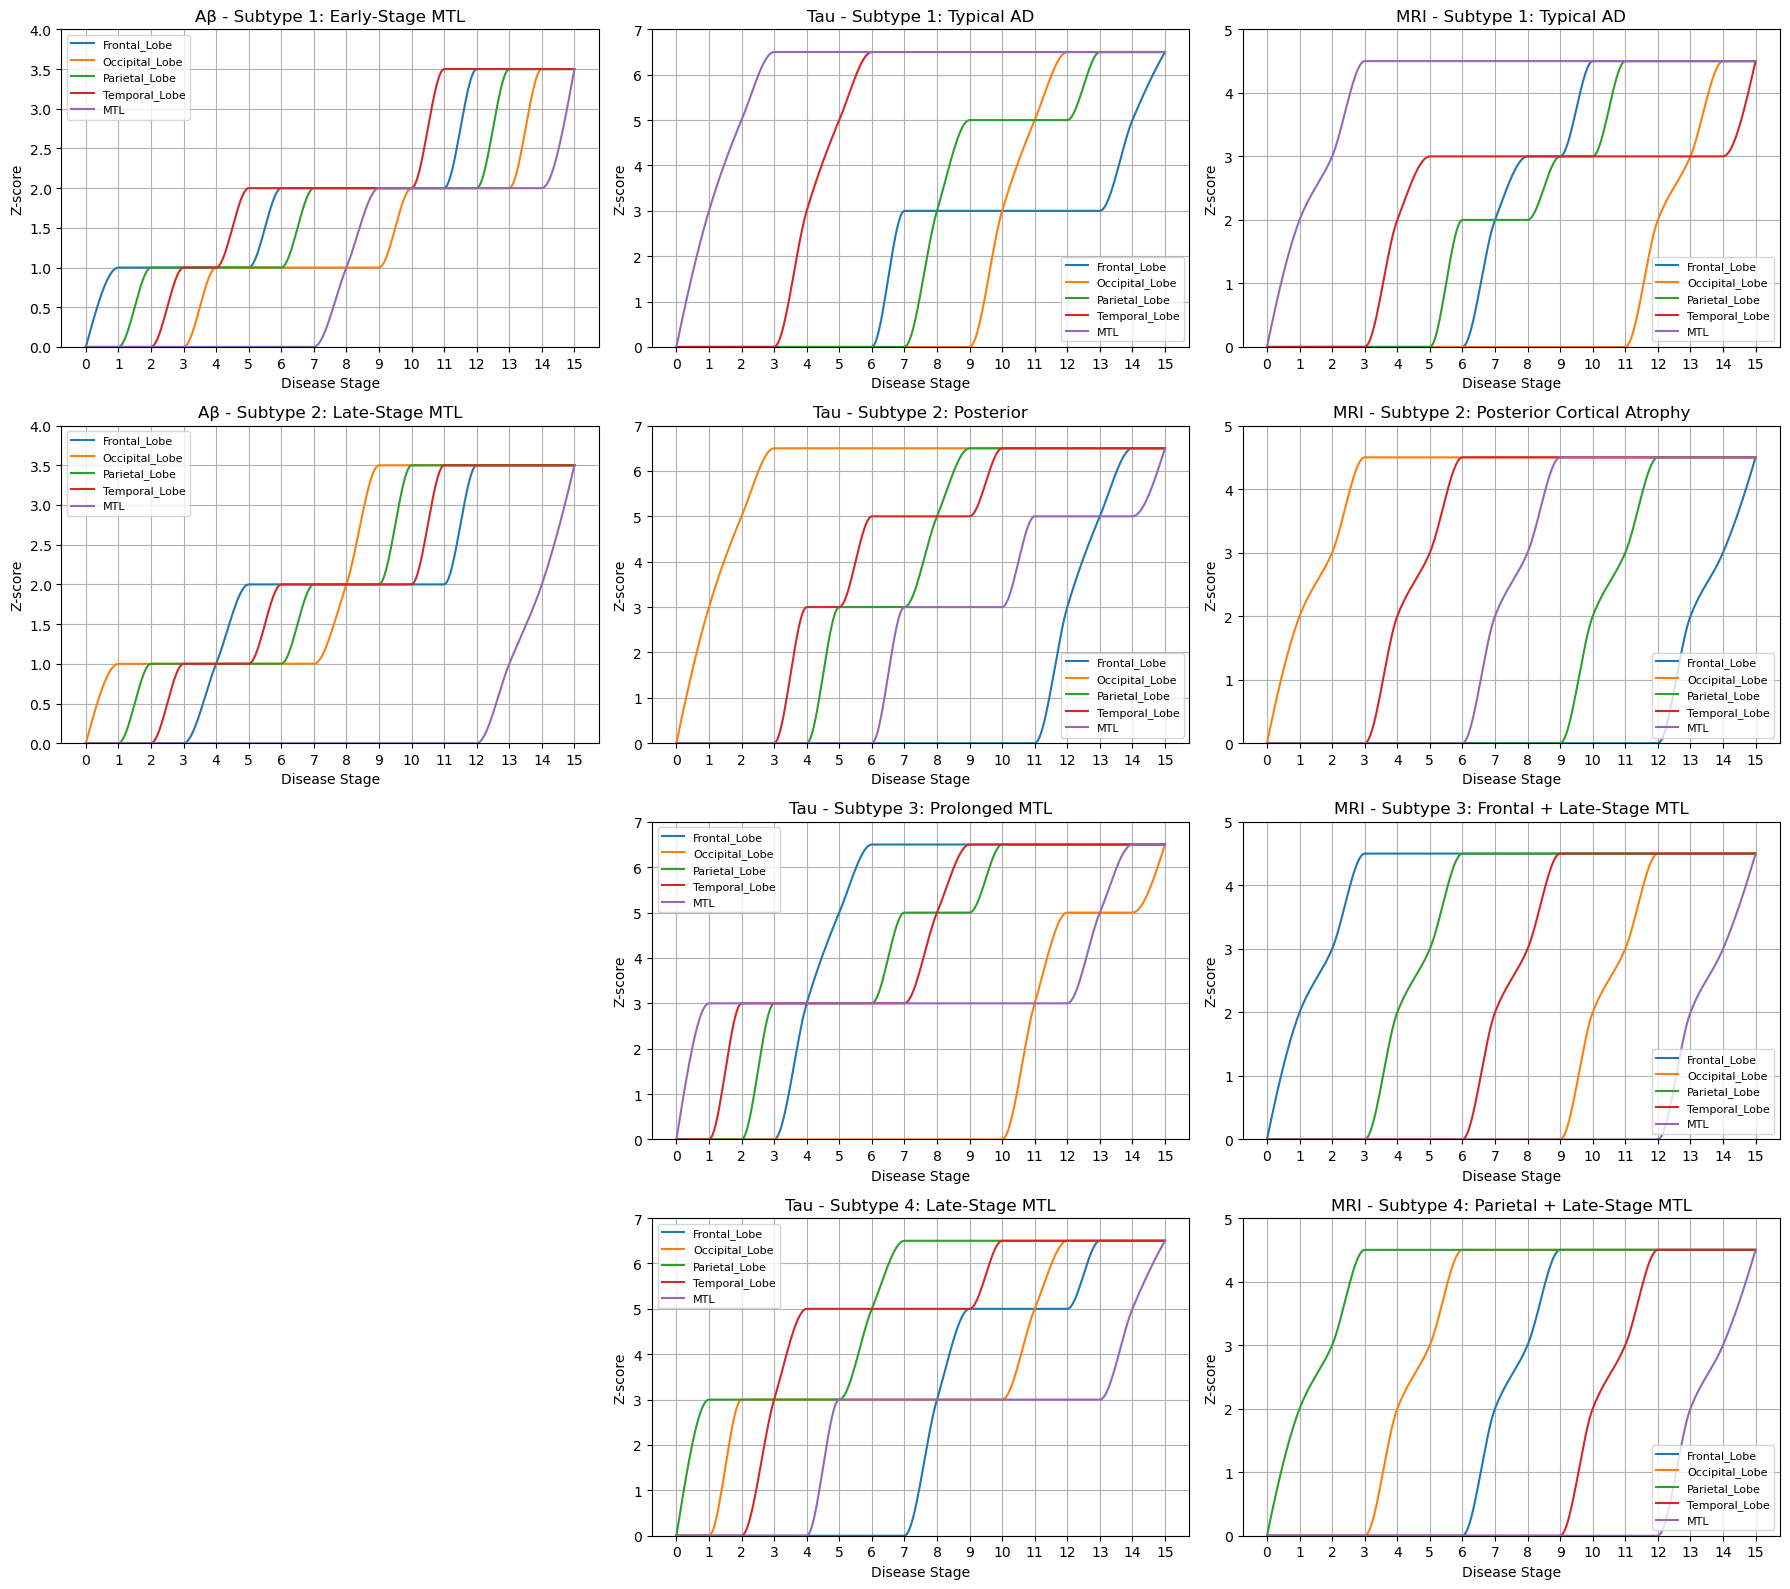

In [49]:
# def plot_progression_signatures(progression_dict, modality_name, ax, subtype_idx):
#     lobes = ['Frontal_Lobe', 'Occipital_Lobe', 'Parietal_Lobe', 'Temporal_Lobe', 'MTL']

#     for lobe in lobes:
#         scores = progression_dict[lobe]
#         scores = np.array(scores)

#         # Replace NaN with 0
#         scores = np.nan_to_num(scores, nan=0.0)
#         stages = np.arange(len(scores))

#         # Enforce non-negative and non-decreasing
#         for i in range(1, len(scores)):
#             scores[i] = max(scores[i], scores[i - 1])

#         # Interpolate
#         interpolator = PchipInterpolator(stages, scores, extrapolate=False)
#         fine_stages = np.linspace(0, len(scores) - 1, 300)
#         smooth_scores = interpolator(fine_stages)

#         # Clip final interpolation result
#         smooth_scores = np.clip(smooth_scores, 0, np.nanmax(scores))

#         ax.plot(fine_stages, smooth_scores, label=lobe)

#     ax.set_title(f"{modality_name} - Subtype {subtype_idx + 1}")
#     ax.set_xticks(np.arange(len(scores)))
#     ax.set_xlabel("Disease Stage")
#     ax.set_ylabel("Z-score")
#     ax.set_ylim(0, np.nanmax(scores) + 0.5)
#     ax.grid(True)
#     ax.legend(fontsize=8)


# # --- Main plotting ---
# n_subtypes = max(len(progression_mri), len(progression_ab), len(progression_tau))
# fig, axes = plt.subplots(n_subtypes, 3, figsize=(18, 4 * n_subtypes), squeeze=False)

# modalities = {
#     "Aβ": progression_ab,
#     "Tau": progression_tau,
#     "MRI": progression_mri,
# }

# for row in range(n_subtypes):
#     for col, (mod_name, prog_dict) in enumerate(modalities.items()):
#         ax = axes[row, col]
#         if row < len(prog_dict):
#             # Pass the actual subtype index (row) here
#             plot_progression_signatures(prog_dict[row], mod_name, ax, row)
#         else:
#             ax.axis('off')

# plt.tight_layout()
# plt.show()
# fig.savefig("subtype_progressions.png", dpi=300)

from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
import numpy as np

def plot_progression_signatures(progression_dict, modality_name, ax, subtype_idx, subtype_names):
    lobes = ['Frontal_Lobe', 'Occipital_Lobe', 'Parietal_Lobe', 'Temporal_Lobe', 'MTL']

    for lobe in lobes:
        scores = progression_dict[lobe]
        scores = np.array(scores)

        # Replace NaN with 0
        scores = np.nan_to_num(scores, nan=0.0)
        stages = np.arange(len(scores))

        # Enforce non-negative and non-decreasing
        for i in range(1, len(scores)):
            scores[i] = max(scores[i], scores[i - 1])

        # Interpolate
        interpolator = PchipInterpolator(stages, scores, extrapolate=False)
        fine_stages = np.linspace(0, len(scores) - 1, 300)
        smooth_scores = interpolator(fine_stages)

        # Clip final interpolation result
        smooth_scores = np.clip(smooth_scores, 0, np.nanmax(scores))

        ax.plot(fine_stages, smooth_scores, label=lobe)

    # --- Add subtype name from provided mapping ---
    subtype_label = subtype_names.get(subtype_idx + 1, "")
    ax.set_title(f"{modality_name} - Subtype {subtype_idx + 1}: {subtype_label}")
    ax.set_xticks(np.arange(len(scores)))
    ax.set_xlabel("Disease Stage")
    ax.set_ylabel("Z-score")
    ax.set_ylim(0, np.nanmax(scores) + 0.5)
    ax.grid(True)
    ax.legend(fontsize=8)


# --- Define subtype name dictionaries ---
subtype_names_ab = {
    1: "Early-Stage MTL",
    2: "Late-Stage MTL"
}

subtype_names_tau = {
    1: "Typical AD",
    2: "Posterior",
    3: "Prolonged MTL",
    4: "Late-Stage MTL"
}

subtype_names_mri = {
    1: "Typical AD",
    2: "Posterior Cortical Atrophy",
    3: "Frontal + Late-Stage MTL",
    4: "Parietal + Late-Stage MTL"
}


# --- Main plotting ---
n_subtypes = max(len(progression_mri), len(progression_ab), len(progression_tau))
fig, axes = plt.subplots(n_subtypes, 3, figsize=(18, 4 * n_subtypes), squeeze=False)

modalities = {
    "Aβ": (progression_ab, subtype_names_ab),
    "Tau": (progression_tau, subtype_names_tau),
    "MRI": (progression_mri, subtype_names_mri),
}

for row in range(n_subtypes):
    for col, (mod_name, (prog_dict, subtype_names)) in enumerate(modalities.items()):
        ax = axes[row, col]
        if row < len(prog_dict):
            plot_progression_signatures(prog_dict[row], mod_name, ax, row, subtype_names)
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()
fig.savefig("subtype_progressions.png", dpi=300)


ml_subtype
0.0    850
1.0     22
Name: count, dtype: int64

In [22]:
# # Flatten all unique entries (stage + lobe) across all sequences
# all_entries = set()
# for modality, subtype_seqs in all_progressions.items():
#     for seq in subtype_seqs:
#         all_entries.update(seq)

# all_entries = sorted(all_entries)  # sorted for consistent ordering
# entry_index = {entry: idx for idx, entry in enumerate(all_entries)}

# def sequence_to_rank_vector_full(seq):
#     """
#     Convert a subtype sequence (list of full strings 'stage: lobe') into a rank vector over all possible entries.
#     If an entry is missing in the sequence, assign rank = len(seq)+1 (last).
#     """
#     n_entries = len(all_entries)
#     rank_vector = np.full(n_entries, len(seq) + 1, dtype=int)
#     for rank, entry in enumerate(seq, start=1):
#         if entry in entry_index:
#             rank_vector[entry_index[entry]] = rank
#     return rank_vector

# # Prepare all rank vectors and labels
# all_rank_vectors = []
# all_labels = []

# for modality, subtype_seqs in all_progressions.items():
#     for i, seq in enumerate(subtype_seqs):
#         all_rank_vectors.append(sequence_to_rank_vector_full(seq))
#         all_labels.append(f"{modality}_sub{i+1}")

# all_rank_vectors = np.array(all_rank_vectors)

# # Compute Kendall tau correlation matrix (pairwise)
# n = len(all_rank_vectors)
# corr_matrix = np.zeros((n, n))

# for i in range(n):
#     for j in range(i, n):
#         tau, _ = kendalltau(all_rank_vectors[i], all_rank_vectors[j])
#         corr_matrix[i, j] = tau
#         corr_matrix[j, i] = tau  # symmetric

# # Convert to DataFrame for nicer plotting
# corr_df = pd.DataFrame(corr_matrix, index=all_labels, columns=all_labels)

# # Plot and save figure
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_df, cmap='coolwarm', annot=True, fmt=".2f", square=True,
#             linewidths=0.5, cbar_kws={"shrink": 0.8})
# plt.title("Kendall's Tau Correlation of Full Subtype Sequences Across Modalities", fontsize=14)
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()

# output_path = "correlation_matrix_full_sequences.png"
# plt.savefig(output_path, dpi=300)
# plt.show()


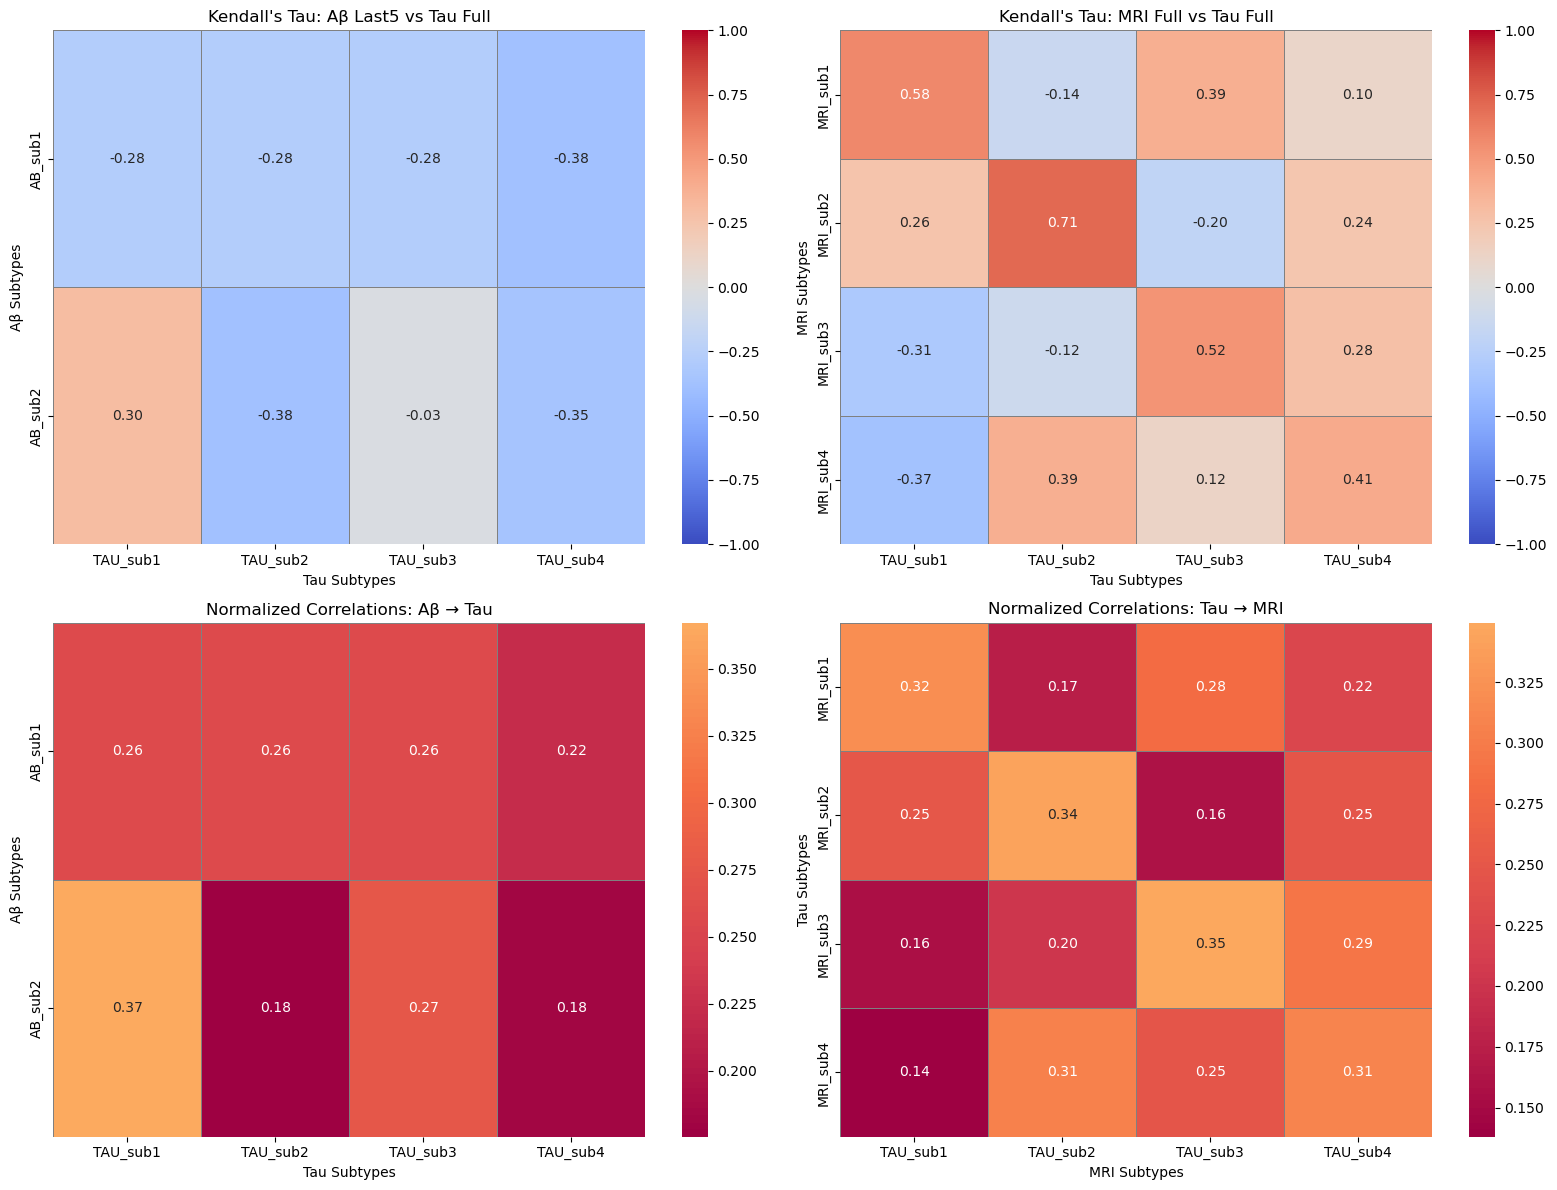

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid

# --- Top row: Kendall's Tau ---
sns.heatmap(corr_ab_tau_df, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1,
            linewidths=0.5, linecolor="gray", ax=axes[0,0])
axes[0,0].set_title("Kendall's Tau: Aβ Last5 vs Tau Full")
axes[0,0].set_ylabel("Aβ Subtypes")
axes[0,0].set_xlabel("Tau Subtypes")

sns.heatmap(corr_mri_tau_df, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1,
            linewidths=0.5, linecolor="gray", ax=axes[0,1])
axes[0,1].set_title("Kendall's Tau: MRI Full vs Tau Full")
axes[0,1].set_ylabel("MRI Subtypes")
axes[0,1].set_xlabel("Tau Subtypes")

# --- Bottom row: Normalized correlations ---
sns.heatmap(norm_ab_tau, annot=True, fmt=".2f", cmap="Spectral", center=0.5,
            linewidths=0.5, linecolor="gray", ax=axes[1,0])
axes[1,0].set_title("Normalized Correlations: Aβ → Tau")
axes[1,0].set_ylabel("Aβ Subtypes")
axes[1,0].set_xlabel("Tau Subtypes")

sns.heatmap(norm_tau_mri, annot=True, fmt=".2f", cmap="Spectral", center=0.5,
            linewidths=0.5, linecolor="gray", ax=axes[1,1])
axes[1,1].set_title("Normalized Correlations: Tau → MRI")
axes[1,1].set_ylabel("Tau Subtypes")
axes[1,1].set_xlabel("MRI Subtypes")

plt.tight_layout()
plt.savefig("combined_heatmaps.png", dpi=300)
plt.show()


## Triplet Subtypes

In [38]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau

# --- Assume your data is loaded: ---
# all_progressions = {'AB': [...], 'TAU': [...], 'MRI': [...]}
# corr_ab_tau_df: pd.DataFrame of shape (n_AB_subtypes, n_TAU_subtypes)
# corr_mri_tau_df: pd.DataFrame of shape (n_TAU_subtypes, n_MRI_subtypes)
# ab_priors, tau_priors, mri_priors: np.arrays with subtype counts or priors

# 1. Dynamically assign sequences from all_progressions dict
for modality, seqs in all_progressions.items():
    for i, seq in enumerate(seqs, start=1):
        var_name = f"{modality.lower()}_subtype_{i}"
        globals()[var_name] = seq

# Pack sequences into lists for convenience
ab_sequences = [globals()[f"ab_subtype_{i}"] for i in range(1, len(all_progressions['AB']) + 1)]
tau_sequences = [globals()[f"tau_subtype_{i}"] for i in range(1, len(all_progressions['TAU']) + 1)]
mri_sequences = [globals()[f"mri_subtype_{i}"] for i in range(1, len(all_progressions['MRI']) + 1)]

# 2. Normalize the correlation matrices
norm_ab_tau = (corr_ab_tau_df + 1) / 2  # scale from [-1,1] to [0,1]
norm_ab_tau = norm_ab_tau.div(norm_ab_tau.sum(axis=1), axis=0)  # normalize rows to sum 1

norm_tau_mri = (corr_mri_tau_df + 1) / 2
norm_tau_mri = norm_tau_mri.div(norm_tau_mri.sum(axis=1), axis=0)

# 3. Normalize priors
ab_counts = np.array([850, 22])
ab_priors = ab_counts/sum(ab_counts)
tau_counts = np.array([262, 226, 64, 25])
tau_priors = tau_counts / tau_counts.sum()
mri_counts = np.array([1249, 21, 12, 11])  
mri_priors = mri_counts / mri_counts.sum()


# 4. Calculate scores for all subtype triplets
triplets = []

for a_idx in range(norm_ab_tau.shape[0]):   # AB subtypes
    for t_idx in range(norm_ab_tau.shape[1]):  # TAU subtypes
        for m_idx in range(norm_tau_mri.shape[1]):  # MRI subtypes
            p_ab = ab_priors[a_idx]
            p_tau = tau_priors[t_idx]
            p_mri = mri_priors[m_idx]

            ab_tau_corr = norm_ab_tau.iloc[a_idx, t_idx]
            tau_mri_corr = norm_tau_mri.iloc[t_idx, m_idx]

            score = p_ab * p_tau * p_mri * ab_tau_corr * tau_mri_corr

            triplets.append({
                'AB': a_idx + 1,
                'Tau': t_idx + 1,
                'MRI': m_idx + 1,
                'P(AB)': round(p_ab, 3),
                'P(Tau)': round(p_tau, 3),
                'P(MRI)': round(p_mri, 3),
                'AB→Tau': round(ab_tau_corr, 3),
                'Tau→MRI': round(tau_mri_corr, 3),
                'Score': score
            })

# 5. Sort triplets by Score descending
triplets_sorted = sorted(triplets, key=lambda x: x['Score'], reverse=True)

# 6. Print top results
print(f"{'Rank':<5} {'Aβ':<5} {'Tau':<5} {'MRI':<5} {'P(Aβ)':<7} {'P(Tau)':<7} {'P(MRI)':<7} {'AB→Tau':<7} {'Tau→MRI':<7} {'Score':<10}")
print('-' * 70)
for i, triplet in enumerate(triplets_sorted):
    print(f"{i+1:<5} {triplet['AB']:<5} {triplet['Tau']:<5} {triplet['MRI']:<5} "
          f"{triplet['P(AB)']:<7} {triplet['P(Tau)']:<7} {triplet['P(MRI)']:<7} "
          f"{triplet['AB→Tau']:<7} {triplet['Tau→MRI']:<7} {triplet['Score']:<10.5f}")


Rank  Aβ    Tau   MRI   P(Aβ)   P(Tau)  P(MRI)  AB→Tau  Tau→MRI Score     
----------------------------------------------------------------------
1     1     1     1     0.975   0.454   0.966   0.259   0.32    0.03549   
2     1     2     1     0.975   0.392   0.966   0.259   0.251   0.02397   
3     1     3     1     0.975   0.111   0.966   0.259   0.157   0.00425   
4     2     1     1     0.025   0.454   0.966   0.367   0.32    0.00130   
5     1     4     1     0.975   0.043   0.966   0.223   0.138   0.00126   
6     1     2     2     0.975   0.392   0.016   0.259   0.342   0.00055   
7     2     2     1     0.025   0.392   0.966   0.175   0.251   0.00042   
8     1     1     2     0.975   0.454   0.016   0.259   0.174   0.00032   
9     1     1     3     0.975   0.454   0.009   0.259   0.282   0.00030   
10    1     1     4     0.975   0.454   0.009   0.259   0.224   0.00022   
11    1     2     4     0.975   0.392   0.009   0.259   0.247   0.00021   
12    1     2     3     0.975

In [39]:
# Convert to DataFrame
triplet_df = pd.DataFrame(triplets_sorted)

# Add Triplet identifier column
triplet_df["Triplet"] = triplet_df.apply(lambda row: f"AB{int(row['AB'])}_TAU{int(row['Tau'])}_MRI{int(row['MRI'])}", axis=1)

# Save to CSV
triplet_df.to_csv("predicted_triplet_scores.csv", index=False, float_format="%.10f")



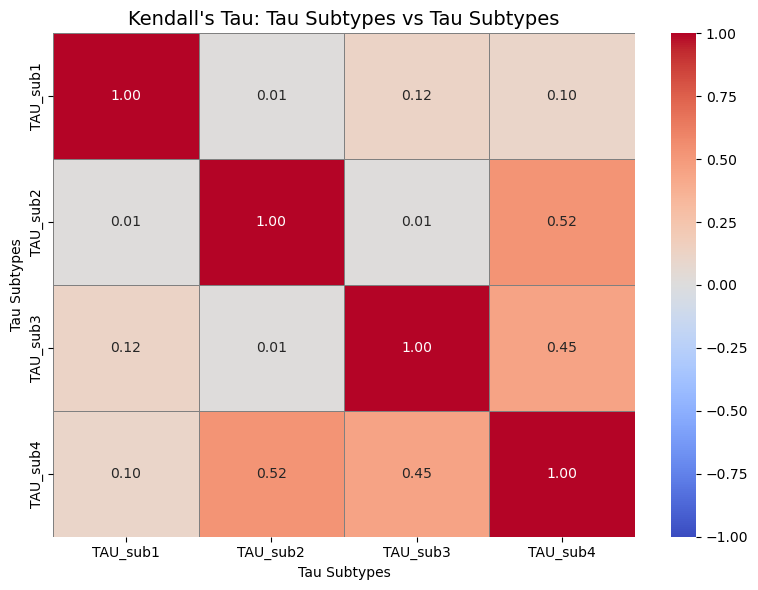

In [41]:
# Number of Tau subtypes
n_tau = len(tau_full_vectors)

# Initialize correlation matrix
corr_tau_tau = np.zeros((n_tau, n_tau))

# Compute Kendall tau correlations for each pair of Tau subtypes
for i in range(n_tau):
    for j in range(n_tau):
        tau_corr, _ = kendalltau(tau_full_vectors[i], tau_full_vectors[j])
        corr_tau_tau[i, j] = tau_corr

# Create dataframe with labels
corr_tau_tau_df = pd.DataFrame(corr_tau_tau, index=tau_full_labels, columns=tau_full_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_tau_tau_df, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            linewidths=0.5, linecolor="gray", fmt=".2f")
plt.title("Kendall's Tau: Tau Subtypes vs Tau Subtypes", fontsize=14)
plt.ylabel("Tau Subtypes")
plt.xlabel("Tau Subtypes")
plt.tight_layout()
plt.savefig("kendall_tau_tau_vs_tau.png", dpi=300)
plt.show()
